In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Assign scores to Chen windows 

In [2]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" # contains header
    f" -b <(cat {b_filename})"        # does not contain header
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)               # contains header
  b_file_header = ['B_chrom', 'B_start', 'B_end', 'B'] # does not contain header

  return a_file_header, b_file_header

def set_column_dtypes(df, column_dtypes, log=False): 
  for col, dtype in column_dtypes.items(): 
    df[col] = df[col].astype(dtype)

  if log: print(dict(df.dtypes))
  return df 

def make_scores_numeric(df): 
  # we don't want to include enhancers that don't overlap any windows with B-values
  df = df[df['B_chrom'] != '.'] 

  # having removed records where 'B_chrom' is '.', we can now convert the column to a float
  df = set_column_dtypes(
    df,   
    column_dtypes = {
      'B': float,
    }
  )

  return df 
  
def assign_scores_to_chen_windows():
  df_gnocchi = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-gnocchi.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'gnocchi']
  )
  df_N_expected = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_expected_gnocchi.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'N_expected']
  )
  df_N_observed = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_observed.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'N_observed']
  )

  df = pd.merge(
    df_gnocchi, 
    df_N_expected, 
    on=['chrom', 'start', 'end'],
    how='inner'
  )
  df = pd.merge(
    df, 
    df_N_observed, 
    on=['chrom', 'start', 'end'],
    how='inner'
  )

  # Chen et al windows: 
  a_filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.bed' 
  df.to_csv(
    a_filename,
    sep='\t',
    index=False,
  )

  # assign B-values to Chen et al. windows 
  b_filename = f'{CONSTRAINT_TOOLS_DATA}/background-selection/CADD-B-map/bmap.hg38.bed' 
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.intersect.bmap.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['chenWindow_BWindow_overlap'],
  )

  df = make_scores_numeric(df)

  # though unlikely, some Chen-windows may intersect multiple B-windows, 
  # so let's group by Chen-window, and aggregare scores over all B-windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'B': [np.max],
    }
  )

  df = df.rename(columns={'max B': 'B'})

  return df

pd.set_option('display.max_columns', 100)

WINDOWS = assign_scores_to_chen_windows()
WINDOWS

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.intersect.bmap.bed
<ipython-input-2-668d11f86fdf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


,chrom,start,end,gnocchi,N_expected,N_observed,B
0,chr1,1432000,1433000,4.299894,338.059552,259,0.653
1,chr1,1435000,1436000,3.331645,333.876799,273,0.652
2,chr1,1449000,1450000,1.817267,253.960193,225,0.652
3,chr1,1450000,1451000,1.365863,337.076763,312,0.652
4,chr1,1451000,1452000,0.666316,302.590657,291,0.652
...,...,...,...,...,...,...,...
1605781,chr9,137269000,137270000,5.276351,300.458958,209,0.536
1605782,chr9,137275000,137276000,2.687348,339.517045,290,0.536
1605783,chr9,137282000,137283000,-0.090791,208.688422,210,0.536
1605784,chr9,137290000,137291000,2.162811,257.721105,223,0.536


## Compute and save BGS-corrected Gnocchi 

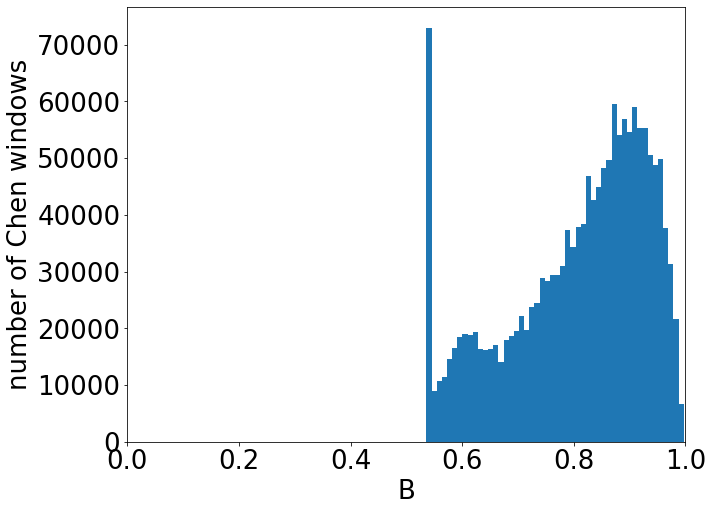

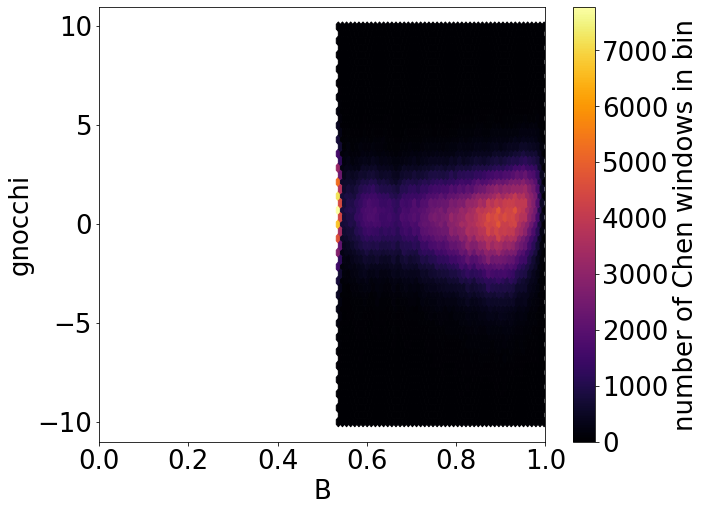

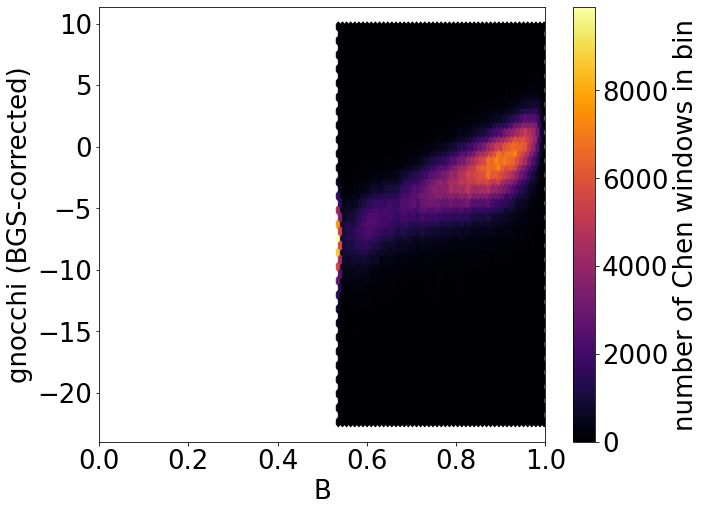

In [3]:
import matplotlib.pyplot as plt

plt.rcParams.update({
  'font.size': 26,
  'figure.figsize': (10, 8),
})

def compute_BGS_corrected_gnocchi(df): 
  plt.hist(df['B'], bins=50)
  plt.xlabel('B')
  plt.ylabel('number of Chen windows')
  plt.xlim(0, 1)
  plt.show()

  plt.hexbin(df['B'], df['gnocchi'], gridsize=50, cmap='inferno')
  plt.colorbar(label='number of Chen windows in bin')
  plt.xlabel('B')
  plt.ylabel('gnocchi')
  plt.xlim(0, 1)
  plt.show() 

  df['N_expected_BGS_corrected'] = df['N_expected'] * df['B']
  df['gnocchi_BGS_corrected'] = (df['N_expected_BGS_corrected'] - df['N_observed']) / np.sqrt(df['N_expected_BGS_corrected'])

  plt.hexbin(df['B'], df['gnocchi_BGS_corrected'], gridsize=50, cmap='inferno')
  plt.colorbar(label='number of Chen windows in bin')
  plt.xlabel('B')
  plt.ylabel('gnocchi (BGS-corrected)')
  plt.xlim(0, 1)
  plt.show() 
  
  df.to_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.bmap.gnocchi_BGS_corrected.csv',
    index=False,
  )

compute_BGS_corrected_gnocchi(WINDOWS)